In [1]:
from climpyrical.gridding import find_nearest_index, find_element_wise_nearest_pos, scale_model_obs
from climpyrical.mask import gen_raster_mask_from_vector, gen_upper_archipelago_mask, stratify_coords
import climpyrical.spytialProcess as sp
from climpyrical.data import read_data, interpolate_dataset, gen_dataset
from climpyrical.rkrig import krigit_north, rkrig_r
from climpyrical.cmd.find_matched_model_vals import add_model_values

from pkg_resources import resource_filename

from rpy2.robjects.packages import importr
import xarray as xr
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from scipy.interpolate import NearestNDInterpolator
from sklearn.neighbors import NearestNeighbors
import pickle

from tqdm import tqdm
import dask.array as da
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import matplotlib


from pykrige.ok import OrdinaryKriging

importr("fields")


%load_ext autoreload
%autoreload 2

In [2]:
# parameter cell
# these currently have default values but are configurable when 
# executing this notebook with papermill

station_dv = "RL50 (kPa)"
station_input_path = resource_filename("climpyrical", "data/station_inputs/Interim_snow_rain_load_LR_composite_stations_tbd_v4.csv")
name = "RL50"
processed_model_output_path = resource_filename("climpyrical", "data/results/intermediate/preprocessed_models/default.nc")
output_reconstruction_path = resource_filename("climpyrical", f"data/results/datasets/RL50_reconstructed.nc")
df_path_write = resource_filename('climpyrical', f'data/results/intermediate/preprocessed_stations/RL50_processed_stations.csv')

In [3]:
# Parameters
station_dv = "RL50 (kPa)"
station_input_path = "/home/nannau/11202020/climpyrical/climpyrical/data/station_inputs/Interim_snow_rain_load_LR_composite_stations_tbd_v4.csv"
filename = "RL50"
processed_model_output_path = "/home/nannau/11202020/climpyrical/climpyrical/data/results/intermediate/preprocessed_models/RL50_preprocessed.nc"
output_reconstruction_path = "/home/nannau/11202020/climpyrical/climpyrical/data/results/datasets/RL50_reconstructed.nc"
df_path_write = "/home/nannau/11202020/climpyrical/climpyrical/data/results/intermediate/preprocessed_stations/RL50_processed_stations.csv"


In [4]:
dsold_max = 28.15999984741211

mask_path = resource_filename(
    'climpyrical',
    'data/masks/canada_mask_rp.nc'
)

north_mask_path = resource_filename(
    'climpyrical',
    'data/masks/canada_mask_north_rp.nc'
)

ds = read_data(processed_model_output_path)
(dv, ) = ds.data_vars
mask = read_data(mask_path)['mask'].values
northern_mask = read_data(north_mask_path)['mask'].values

rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)

In [5]:
df = pd.read_csv(df_path_write, index_col=False)
df.head(5)

,irlat,irlon,id,lon,lat,elev (m),SL50 (kPa),RL50 (kPa),rlat,rlon,model_values,ratio
0,558,1009,6038.0,-82.95560,42.27560,190.0,1.0,0.402,-4.286849,10.373390,0.285755,1.179944
1,559,1009,6037.0,-82.93330,42.33330,188.0,1.2,0.484,-4.227125,10.379271,0.286351,1.417673
2,576,1017,5880.0,-82.30470,42.99220,181.0,1.5,0.389,-3.494586,10.713492,0.286172,1.140122
3,577,1048,123.0,-80.42906,42.77439,214.0,1.4,0.470,-3.434479,12.106219,0.320984,1.228128
4,579,1046,5921.0,-80.55000,42.86670,232.0,1.5,0.587,-3.362845,11.999925,0.317087,1.552705


separate stations into beyond and within the model domain

In [6]:
df_north = df[df.rlat > dsold_max].copy()
df_south = df[df.rlat <= dsold_max].copy()

north_index = df_north.index.values
south_index = df_south.index.values

# Krig the station only values in the north

In [7]:
UAA_station_mean = np.nanmean(df[station_dv][df.rlat > dsold_max-1])

In [8]:
# choose starting value
# model_vals = ds[dv].values[df.ilocy.values, df.ilocx.values]
model_vals = df.model_values
station_vals = df[station_dv]

ratio, best_tol = scale_model_obs(df.model_values, station_vals)

# apply correction
model_vals_corrected = (model_vals/best_tol)
mean_corrected = (ds[dv].values/best_tol)

print(best_tol)

0.8387427753361661


In [9]:
np.seterr(divide='ignore', invalid='ignore')
ratio_field = rkrig_r(df_south, 30, ds, station_dv)
ratio_field[~mask] = np.nan

  0%|          | 0/411 [00:00<?, ?it/s]

  0%|          | 2/411 [00:00<02:15,  3.02it/s]

  1%|          | 3/411 [00:01<02:40,  2.53it/s]

  1%|          | 4/411 [00:01<02:58,  2.28it/s]

  1%|          | 5/411 [00:02<03:10,  2.13it/s]

  1%|▏         | 6/411 [00:02<03:17,  2.05it/s]

  2%|▏         | 7/411 [00:03<03:23,  1.99it/s]

  2%|▏         | 8/411 [00:03<03:26,  1.95it/s]

  2%|▏         | 9/411 [00:04<03:29,  1.92it/s]

  2%|▏         | 10/411 [00:04<03:31,  1.90it/s]

  3%|▎         | 11/411 [00:05<03:32,  1.89it/s]

  3%|▎         | 12/411 [00:06<03:32,  1.87it/s]

  3%|▎         | 13/411 [00:06<03:32,  1.87it/s]

  3%|▎         | 14/411 [00:07<03:31,  1.88it/s]

  4%|▎         | 15/411 [00:07<03:30,  1.88it/s]

  4%|▍         | 16/411 [00:08<03:30,  1.88it/s]

  4%|▍         | 17/411 [00:08<03:29,  1.88it/s]

  4%|▍         | 18/411 [00:09<03:28,  1.89it/s]

  5%|▍         | 19/411 [00:09<03:27,  1.89it/s]

  5%|▍         | 20/411 [00:10<03:27,  1.89it/s]

  5%|▌         | 21/411 [00:10<03:26,  1.89it/s]

  5%|▌         | 22/411 [00:11<03:27,  1.88it/s]

  6%|▌         | 23/411 [00:11<03:26,  1.88it/s]

  6%|▌         | 24/411 [00:12<03:26,  1.87it/s]

  6%|▌         | 25/411 [00:12<03:26,  1.87it/s]

  6%|▋         | 26/411 [00:13<03:25,  1.87it/s]

  7%|▋         | 27/411 [00:14<03:25,  1.87it/s]

  7%|▋         | 28/411 [00:14<03:29,  1.83it/s]

  7%|▋         | 29/411 [00:15<03:28,  1.83it/s]

  7%|▋         | 30/411 [00:15<03:27,  1.84it/s]

  8%|▊         | 31/411 [00:16<03:26,  1.84it/s]

  8%|▊         | 32/411 [00:16<03:25,  1.85it/s]

  8%|▊         | 33/411 [00:17<03:26,  1.83it/s]

  8%|▊         | 34/411 [00:17<03:25,  1.83it/s]

  9%|▊         | 35/411 [00:18<03:24,  1.84it/s]

  9%|▉         | 36/411 [00:18<03:23,  1.85it/s]

  9%|▉         | 37/411 [00:19<03:23,  1.83it/s]

  9%|▉         | 38/411 [00:20<03:23,  1.83it/s]

  9%|▉         | 39/411 [00:20<03:23,  1.83it/s]

 10%|▉         | 40/411 [00:21<03:23,  1.83it/s]

 10%|▉         | 41/411 [00:21<03:22,  1.83it/s]

 10%|█         | 42/411 [00:22<03:25,  1.80it/s]

 10%|█         | 43/411 [00:22<03:22,  1.82it/s]

 11%|█         | 44/411 [00:23<03:19,  1.84it/s]

 11%|█         | 45/411 [00:23<03:24,  1.79it/s]

 11%|█         | 46/411 [00:24<03:20,  1.82it/s]

 11%|█▏        | 47/411 [00:25<03:19,  1.83it/s]

 12%|█▏        | 48/411 [00:25<03:15,  1.86it/s]

 12%|█▏        | 49/411 [00:26<03:16,  1.84it/s]

 12%|█▏        | 50/411 [00:26<03:16,  1.84it/s]

 12%|█▏        | 51/411 [00:27<03:16,  1.83it/s]

 13%|█▎        | 52/411 [00:27<03:13,  1.86it/s]

 13%|█▎        | 53/411 [00:28<03:18,  1.80it/s]

 13%|█▎        | 54/411 [00:28<03:22,  1.77it/s]

 13%|█▎        | 55/411 [00:29<03:23,  1.75it/s]

 14%|█▎        | 56/411 [00:30<03:20,  1.77it/s]

 14%|█▍        | 57/411 [00:30<03:17,  1.79it/s]

 14%|█▍        | 58/411 [00:31<03:12,  1.83it/s]

 14%|█▍        | 59/411 [00:31<03:13,  1.82it/s]

 15%|█▍        | 60/411 [00:32<03:13,  1.82it/s]

 15%|█▍        | 61/411 [00:32<03:09,  1.85it/s]

 15%|█▌        | 62/411 [00:33<03:11,  1.82it/s]

 15%|█▌        | 63/411 [00:33<03:07,  1.85it/s]

 16%|█▌        | 64/411 [00:34<03:10,  1.82it/s]

 16%|█▌        | 65/411 [00:34<03:06,  1.85it/s]

 16%|█▌        | 66/411 [00:35<03:04,  1.87it/s]

 16%|█▋        | 67/411 [00:35<03:03,  1.88it/s]

 17%|█▋        | 68/411 [00:36<03:03,  1.87it/s]

 17%|█▋        | 69/411 [00:37<03:02,  1.88it/s]

 17%|█▋        | 70/411 [00:37<03:01,  1.88it/s]

 17%|█▋        | 71/411 [00:38<03:01,  1.88it/s]

 18%|█▊        | 72/411 [00:38<02:59,  1.89it/s]

 18%|█▊        | 73/411 [00:39<02:58,  1.89it/s]

 18%|█▊        | 74/411 [00:39<02:56,  1.91it/s]

 18%|█▊        | 75/411 [00:40<02:57,  1.89it/s]

 18%|█▊        | 76/411 [00:40<02:56,  1.90it/s]

 19%|█▊        | 77/411 [00:41<02:55,  1.91it/s]

 19%|█▉        | 78/411 [00:41<02:54,  1.90it/s]

 19%|█▉        | 79/411 [00:42<02:54,  1.90it/s]

 19%|█▉        | 80/411 [00:42<02:54,  1.90it/s]

 20%|█▉        | 81/411 [00:43<02:54,  1.90it/s]

 20%|█▉        | 82/411 [00:43<02:52,  1.91it/s]

 20%|██        | 83/411 [00:44<02:54,  1.88it/s]

 20%|██        | 84/411 [00:44<02:53,  1.88it/s]

 21%|██        | 85/411 [00:45<02:51,  1.90it/s]

 21%|██        | 86/411 [00:45<02:53,  1.88it/s]

 21%|██        | 87/411 [00:46<02:55,  1.85it/s]

 21%|██▏       | 88/411 [00:47<02:54,  1.85it/s]

 22%|██▏       | 89/411 [00:47<02:51,  1.88it/s]

 22%|██▏       | 90/411 [00:48<02:53,  1.85it/s]

 22%|██▏       | 91/411 [00:48<02:51,  1.87it/s]

 22%|██▏       | 92/411 [00:49<02:50,  1.87it/s]

 23%|██▎       | 93/411 [00:49<02:48,  1.89it/s]

 23%|██▎       | 94/411 [00:50<02:48,  1.88it/s]

 23%|██▎       | 95/411 [00:50<02:47,  1.88it/s]

 23%|██▎       | 96/411 [00:51<02:46,  1.89it/s]

 24%|██▎       | 97/411 [00:51<02:46,  1.89it/s]

 24%|██▍       | 98/411 [00:53<04:23,  1.19it/s]

 24%|██▍       | 99/411 [00:53<03:53,  1.33it/s]

 24%|██▍       | 100/411 [00:54<03:32,  1.47it/s]

 25%|██▍       | 101/411 [00:55<03:17,  1.57it/s]

 25%|██▍       | 102/411 [00:55<03:07,  1.65it/s]

 25%|██▌       | 103/411 [00:56<03:00,  1.71it/s]

 25%|██▌       | 104/411 [00:56<03:04,  1.67it/s]

 26%|██▌       | 105/411 [00:57<02:59,  1.71it/s]

 26%|██▌       | 106/411 [00:59<04:45,  1.07it/s]

 26%|██▌       | 107/411 [00:59<04:15,  1.19it/s]

 26%|██▋       | 108/411 [01:00<03:45,  1.34it/s]

 27%|██▋       | 109/411 [01:00<03:25,  1.47it/s]

 27%|██▋       | 110/411 [01:01<03:12,  1.57it/s]

 27%|██▋       | 111/411 [01:01<03:01,  1.65it/s]

 27%|██▋       | 112/411 [01:02<02:56,  1.69it/s]

 27%|██▋       | 113/411 [01:02<02:51,  1.74it/s]

 28%|██▊       | 114/411 [01:03<02:47,  1.77it/s]

 28%|██▊       | 115/411 [01:03<02:44,  1.80it/s]

 28%|██▊       | 116/411 [01:04<02:46,  1.78it/s]

 28%|██▊       | 117/411 [01:05<02:42,  1.81it/s]

 29%|██▊       | 118/411 [01:05<02:39,  1.84it/s]

 29%|██▉       | 119/411 [01:06<02:37,  1.86it/s]

 29%|██▉       | 120/411 [01:06<02:35,  1.87it/s]

 29%|██▉       | 121/411 [01:07<02:35,  1.86it/s]

 30%|██▉       | 122/411 [01:07<02:35,  1.85it/s]

 30%|██▉       | 123/411 [01:08<02:36,  1.84it/s]

 30%|███       | 124/411 [01:08<02:35,  1.85it/s]

 30%|███       | 125/411 [01:09<02:35,  1.84it/s]

 31%|███       | 126/411 [01:10<03:56,  1.21it/s]

 31%|███       | 127/411 [01:11<03:31,  1.35it/s]

 31%|███       | 128/411 [01:11<03:13,  1.47it/s]

 31%|███▏      | 129/411 [01:12<02:59,  1.57it/s]

 32%|███▏      | 130/411 [01:12<02:50,  1.65it/s]

 32%|███▏      | 131/411 [01:14<04:37,  1.01it/s]

 32%|███▏      | 132/411 [01:15<03:59,  1.17it/s]

 32%|███▏      | 133/411 [01:15<03:32,  1.31it/s]

 33%|███▎      | 134/411 [01:17<04:33,  1.01it/s]

 33%|███▎      | 135/411 [01:18<03:56,  1.17it/s]

 33%|███▎      | 136/411 [01:18<03:28,  1.32it/s]

 33%|███▎      | 137/411 [01:19<03:09,  1.45it/s]

 34%|███▎      | 138/411 [01:19<02:55,  1.56it/s]

 34%|███▍      | 139/411 [01:20<02:46,  1.64it/s]

 34%|███▍      | 140/411 [01:20<02:45,  1.63it/s]

 34%|███▍      | 141/411 [01:21<02:40,  1.69it/s]

 35%|███▍      | 142/411 [01:21<02:35,  1.73it/s]

 35%|███▍      | 143/411 [01:22<02:37,  1.70it/s]

 35%|███▌      | 144/411 [01:23<02:32,  1.75it/s]

 35%|███▌      | 145/411 [01:23<02:30,  1.77it/s]

 36%|███▌      | 146/411 [01:24<02:28,  1.79it/s]

 36%|███▌      | 147/411 [01:24<02:25,  1.81it/s]

 36%|███▌      | 148/411 [01:25<02:25,  1.81it/s]

 36%|███▋      | 149/411 [01:25<02:23,  1.83it/s]

 36%|███▋      | 150/411 [01:27<03:54,  1.11it/s]

 37%|███▋      | 151/411 [01:28<03:29,  1.24it/s]

 37%|███▋      | 152/411 [01:28<03:06,  1.39it/s]

 37%|███▋      | 153/411 [01:29<02:52,  1.49it/s]

 37%|███▋      | 154/411 [01:29<02:41,  1.59it/s]

 38%|███▊      | 155/411 [01:31<03:37,  1.18it/s]

 38%|███▊      | 156/411 [01:32<04:38,  1.09s/it]

 38%|███▊      | 157/411 [01:34<05:43,  1.35s/it]

 38%|███▊      | 158/411 [01:35<04:40,  1.11s/it]

 39%|███▊      | 159/411 [01:36<05:11,  1.24s/it]

 39%|███▉      | 160/411 [01:37<04:19,  1.03s/it]

 39%|███▉      | 161/411 [01:37<03:41,  1.13it/s]

 39%|███▉      | 162/411 [01:38<03:14,  1.28it/s]

 40%|███▉      | 163/411 [01:38<02:59,  1.38it/s]

 40%|███▉      | 164/411 [01:40<03:46,  1.09it/s]

 40%|████      | 165/411 [01:40<03:17,  1.24it/s]

 40%|████      | 166/411 [01:41<02:56,  1.39it/s]

 41%|████      | 167/411 [01:42<02:59,  1.36it/s]

 41%|████      | 168/411 [01:42<02:43,  1.49it/s]

 41%|████      | 169/411 [01:44<04:30,  1.12s/it]

 41%|████▏     | 170/411 [01:45<03:54,  1.03it/s]

 42%|████▏     | 171/411 [01:46<03:26,  1.16it/s]

 42%|████▏     | 172/411 [01:46<03:09,  1.26it/s]

 42%|████▏     | 173/411 [01:47<02:49,  1.40it/s]

 42%|████▏     | 174/411 [01:47<02:36,  1.51it/s]

 43%|████▎     | 175/411 [01:48<02:27,  1.60it/s]

 43%|████▎     | 176/411 [01:48<02:21,  1.66it/s]

 43%|████▎     | 177/411 [01:49<02:16,  1.71it/s]

 43%|████▎     | 178/411 [01:49<02:13,  1.74it/s]

 44%|████▎     | 179/411 [01:50<02:13,  1.73it/s]

 44%|████▍     | 180/411 [01:51<02:10,  1.78it/s]

 44%|████▍     | 181/411 [01:52<03:42,  1.03it/s]

 44%|████▍     | 182/411 [01:53<03:12,  1.19it/s]

 45%|████▍     | 183/411 [01:55<04:36,  1.21s/it]

 45%|████▍     | 184/411 [01:57<04:58,  1.32s/it]

 45%|████▌     | 185/411 [01:58<05:06,  1.36s/it]

 45%|████▌     | 186/411 [01:59<04:10,  1.11s/it]

 45%|████▌     | 187/411 [02:00<04:22,  1.17s/it]

 46%|████▌     | 188/411 [02:02<04:58,  1.34s/it]

 46%|████▌     | 189/411 [02:04<05:39,  1.53s/it]

 46%|████▌     | 190/411 [02:04<04:32,  1.23s/it]

 46%|████▋     | 191/411 [02:06<04:42,  1.28s/it]

 47%|████▋     | 192/411 [02:07<04:36,  1.26s/it]

 47%|████▋     | 193/411 [02:07<03:48,  1.05s/it]

 47%|████▋     | 194/411 [02:08<03:15,  1.11it/s]

 47%|████▋     | 195/411 [02:08<02:50,  1.27it/s]

 48%|████▊     | 196/411 [02:09<02:39,  1.35it/s]

 48%|████▊     | 197/411 [02:11<03:28,  1.03it/s]

 48%|████▊     | 198/411 [02:11<03:00,  1.18it/s]

 48%|████▊     | 199/411 [02:13<04:01,  1.14s/it]

 49%|████▊     | 200/411 [02:14<04:03,  1.16s/it]

 49%|████▉     | 201/411 [02:16<04:26,  1.27s/it]

 49%|████▉     | 202/411 [02:16<03:40,  1.06s/it]

 49%|████▉     | 203/411 [02:18<04:07,  1.19s/it]

 50%|████▉     | 204/411 [02:19<04:31,  1.31s/it]

 50%|████▉     | 205/411 [02:21<05:02,  1.47s/it]

 50%|█████     | 206/411 [02:22<04:03,  1.19s/it]

 50%|█████     | 207/411 [02:23<04:26,  1.31s/it]

 51%|█████     | 208/411 [02:25<04:40,  1.38s/it]

 51%|█████     | 209/411 [02:25<03:48,  1.13s/it]

 51%|█████     | 210/411 [02:26<03:12,  1.05it/s]

 51%|█████▏    | 211/411 [02:26<02:46,  1.20it/s]

 52%|█████▏    | 212/411 [02:27<02:28,  1.34it/s]

 52%|█████▏    | 213/411 [02:28<02:15,  1.46it/s]

 52%|█████▏    | 214/411 [02:28<02:06,  1.55it/s]

 52%|█████▏    | 215/411 [02:29<02:00,  1.63it/s]

 53%|█████▎    | 216/411 [02:30<02:57,  1.10it/s]

 53%|█████▎    | 217/411 [02:32<03:23,  1.05s/it]

 53%|█████▎    | 218/411 [02:32<02:53,  1.11it/s]

 53%|█████▎    | 219/411 [02:33<02:31,  1.27it/s]

 54%|█████▎    | 220/411 [02:33<02:15,  1.41it/s]

 54%|█████▍    | 221/411 [02:35<02:53,  1.09it/s]

 54%|█████▍    | 222/411 [02:35<02:32,  1.24it/s]

 54%|█████▍    | 223/411 [02:36<02:16,  1.38it/s]

 55%|█████▍    | 224/411 [02:36<02:04,  1.50it/s]

 55%|█████▍    | 225/411 [02:38<03:22,  1.09s/it]

 55%|█████▍    | 226/411 [02:39<02:51,  1.08it/s]

 55%|█████▌    | 227/411 [02:39<02:29,  1.23it/s]

 55%|█████▌    | 228/411 [02:41<02:59,  1.02it/s]

 56%|█████▌    | 229/411 [02:42<03:28,  1.14s/it]

 56%|█████▌    | 230/411 [02:44<03:54,  1.30s/it]

 56%|█████▌    | 231/411 [02:45<03:55,  1.31s/it]

 56%|█████▋    | 232/411 [02:46<03:20,  1.12s/it]

 57%|█████▋    | 233/411 [02:47<02:55,  1.01it/s]

 57%|█████▋    | 234/411 [02:48<03:16,  1.11s/it]

 57%|█████▋    | 235/411 [02:49<03:31,  1.20s/it]

 57%|█████▋    | 236/411 [02:51<03:45,  1.29s/it]

 58%|█████▊    | 237/411 [02:53<04:00,  1.38s/it]

 58%|█████▊    | 238/411 [02:54<04:13,  1.46s/it]

 58%|█████▊    | 239/411 [02:56<04:08,  1.44s/it]

 58%|█████▊    | 240/411 [02:57<04:15,  1.50s/it]

 59%|█████▊    | 241/411 [02:59<04:03,  1.43s/it]

 59%|█████▉    | 242/411 [03:00<04:13,  1.50s/it]

 59%|█████▉    | 243/411 [03:01<03:26,  1.23s/it]

 59%|█████▉    | 244/411 [03:01<02:56,  1.06s/it]

 60%|█████▉    | 245/411 [03:02<02:30,  1.10it/s]

 60%|█████▉    | 246/411 [03:04<03:23,  1.23s/it]

 60%|██████    | 247/411 [03:06<03:42,  1.36s/it]

 60%|██████    | 248/411 [03:06<03:04,  1.13s/it]

 61%|██████    | 249/411 [03:08<03:42,  1.37s/it]

 61%|██████    | 250/411 [03:09<03:03,  1.14s/it]

 61%|██████    | 251/411 [03:10<03:21,  1.26s/it]

 61%|██████▏   | 252/411 [03:12<03:47,  1.43s/it]

 62%|██████▏   | 253/411 [03:14<03:47,  1.44s/it]

 62%|██████▏   | 254/411 [03:14<03:05,  1.18s/it]

 62%|██████▏   | 255/411 [03:15<02:35,  1.00it/s]

 62%|██████▏   | 256/411 [03:16<02:48,  1.09s/it]

 63%|██████▎   | 257/411 [03:18<03:09,  1.23s/it]

 63%|██████▎   | 258/411 [03:19<03:12,  1.26s/it]

 63%|██████▎   | 259/411 [03:19<02:38,  1.04s/it]

 63%|██████▎   | 260/411 [03:20<02:14,  1.12it/s]

 64%|██████▎   | 261/411 [03:21<01:59,  1.26it/s]

 64%|██████▎   | 262/411 [03:22<02:19,  1.07it/s]

R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0



R[write to console]: In addition: 


R[write to console]: Warning messages:



R[write to console]: 1: 


R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :


R[write to console]: 
 


R[write to console]:  library ‘/usr/local/lib/R/site-library’ contains no packages



R[write to console]: 2: 


R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :


R[write to console]: 
 


R[write to console]:  library ‘/usr/local/lib/R/site-library’ contains no packages



R[write to console]: 3: 


R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :


R[write to console]: 
 


R[write to console]:  library ‘/usr/local/lib/R/site-library’ contains no packages



R[write to console]: Timing stopped at: 0.059 0 0.058



 64%|██████▍   | 263/411 [03:22<01:45,  1.41it/s]

 64%|██████▍   | 264/411 [03:24<02:25,  1.01it/s]

 64%|██████▍   | 265/411 [03:25<02:55,  1.20s/it]

 65%|██████▍   | 266/411 [03:27<03:19,  1.38s/it]

 65%|██████▍   | 267/411 [03:28<02:52,  1.20s/it]

 65%|██████▌   | 268/411 [03:29<02:54,  1.22s/it]

 65%|██████▌   | 269/411 [03:31<03:12,  1.35s/it]

 66%|██████▌   | 270/411 [03:33<03:26,  1.46s/it]

 66%|██████▌   | 271/411 [03:34<03:38,  1.56s/it]

 66%|██████▌   | 272/411 [03:36<03:55,  1.70s/it]

 66%|██████▋   | 273/411 [03:38<03:47,  1.65s/it]

 67%|██████▋   | 274/411 [03:39<03:27,  1.52s/it]

 67%|██████▋   | 275/411 [03:41<03:39,  1.61s/it]

 67%|██████▋   | 276/411 [03:42<02:55,  1.30s/it]

 67%|██████▋   | 277/411 [03:42<02:24,  1.08s/it]

 68%|██████▊   | 278/411 [03:44<02:36,  1.18s/it]

 68%|██████▊   | 279/411 [03:45<02:59,  1.36s/it]

 68%|██████▊   | 280/411 [03:47<03:10,  1.45s/it]

 68%|██████▊   | 281/411 [03:49<03:11,  1.47s/it]

 69%|██████▊   | 282/411 [03:50<02:58,  1.39s/it]

 69%|██████▉   | 283/411 [03:52<03:15,  1.52s/it]

 69%|██████▉   | 284/411 [03:53<03:18,  1.56s/it]

 69%|██████▉   | 285/411 [03:54<03:02,  1.45s/it]

 70%|██████▉   | 286/411 [03:56<02:51,  1.37s/it]

 70%|██████▉   | 287/411 [03:57<02:53,  1.40s/it]

 70%|███████   | 288/411 [03:59<03:06,  1.52s/it]

 70%|███████   | 289/411 [04:00<02:55,  1.44s/it]

 71%|███████   | 290/411 [04:01<02:22,  1.18s/it]

 71%|███████   | 291/411 [04:03<02:47,  1.40s/it]

 71%|███████   | 292/411 [04:04<02:41,  1.36s/it]

 71%|███████▏  | 293/411 [04:05<02:46,  1.41s/it]

 72%|███████▏  | 294/411 [04:06<02:15,  1.16s/it]

 72%|███████▏  | 295/411 [04:08<02:30,  1.30s/it]

 72%|███████▏  | 296/411 [04:10<02:53,  1.51s/it]

 72%|███████▏  | 297/411 [04:11<03:00,  1.58s/it]

 73%|███████▎  | 298/411 [04:13<03:08,  1.67s/it]

 73%|███████▎  | 299/411 [04:15<03:09,  1.69s/it]

 73%|███████▎  | 300/411 [04:17<03:08,  1.69s/it]

 73%|███████▎  | 301/411 [04:19<03:15,  1.78s/it]

 73%|███████▎  | 302/411 [04:20<03:10,  1.75s/it]

 74%|███████▎  | 303/411 [04:22<03:13,  1.79s/it]

 74%|███████▍  | 304/411 [04:24<03:05,  1.73s/it]

 74%|███████▍  | 305/411 [04:26<03:07,  1.76s/it]

 74%|███████▍  | 306/411 [04:27<03:03,  1.74s/it]

 75%|███████▍  | 307/411 [04:28<02:25,  1.40s/it]

 75%|███████▍  | 308/411 [04:29<02:17,  1.34s/it]

 75%|███████▌  | 309/411 [04:31<02:20,  1.38s/it]

 75%|███████▌  | 310/411 [04:32<02:22,  1.42s/it]

 76%|███████▌  | 311/411 [04:33<01:55,  1.15s/it]

 76%|███████▌  | 312/411 [04:34<02:03,  1.25s/it]

 76%|███████▌  | 313/411 [04:35<02:03,  1.26s/it]

 76%|███████▋  | 314/411 [04:37<02:17,  1.41s/it]

 77%|███████▋  | 315/411 [04:38<02:13,  1.39s/it]

 77%|███████▋  | 316/411 [04:40<02:19,  1.47s/it]

 77%|███████▋  | 317/411 [04:42<02:25,  1.55s/it]

 77%|███████▋  | 318/411 [04:44<02:32,  1.64s/it]

 78%|███████▊  | 319/411 [04:45<02:23,  1.56s/it]

 78%|███████▊  | 320/411 [04:47<02:18,  1.53s/it]

 78%|███████▊  | 321/411 [04:48<02:11,  1.47s/it]

 78%|███████▊  | 322/411 [04:50<02:23,  1.61s/it]

 79%|███████▊  | 323/411 [04:51<02:17,  1.57s/it]

 79%|███████▉  | 324/411 [04:53<02:10,  1.50s/it]

 79%|███████▉  | 325/411 [04:54<02:06,  1.47s/it]

 79%|███████▉  | 326/411 [04:55<01:41,  1.20s/it]

 80%|███████▉  | 327/411 [04:55<01:24,  1.00s/it]

 80%|███████▉  | 328/411 [04:57<01:35,  1.15s/it]

 80%|████████  | 329/411 [04:58<01:41,  1.23s/it]

 80%|████████  | 330/411 [04:59<01:36,  1.19s/it]

 81%|████████  | 331/411 [05:00<01:19,  1.00it/s]

 81%|████████  | 332/411 [05:01<01:30,  1.14s/it]

 81%|████████  | 333/411 [05:02<01:15,  1.04it/s]

 81%|████████▏ | 334/411 [05:04<01:34,  1.22s/it]

 82%|████████▏ | 335/411 [05:05<01:38,  1.29s/it]

 82%|████████▏ | 336/411 [05:06<01:20,  1.07s/it]

 82%|████████▏ | 337/411 [05:06<01:07,  1.10it/s]

 82%|████████▏ | 338/411 [05:08<01:24,  1.16s/it]

 82%|████████▏ | 339/411 [05:09<01:33,  1.30s/it]

 83%|████████▎ | 340/411 [05:11<01:38,  1.39s/it]

 83%|████████▎ | 341/411 [05:13<01:42,  1.46s/it]

 83%|████████▎ | 342/411 [05:14<01:44,  1.51s/it]

 83%|████████▎ | 343/411 [05:16<01:49,  1.61s/it]

 84%|████████▎ | 344/411 [05:17<01:26,  1.29s/it]

 84%|████████▍ | 345/411 [05:17<01:10,  1.07s/it]

 84%|████████▍ | 346/411 [05:19<01:25,  1.31s/it]

 84%|████████▍ | 347/411 [05:21<01:35,  1.49s/it]

 85%|████████▍ | 348/411 [05:22<01:16,  1.21s/it]

 85%|████████▍ | 349/411 [05:24<01:34,  1.53s/it]

 85%|████████▌ | 350/411 [05:25<01:19,  1.31s/it]

 85%|████████▌ | 351/411 [05:25<01:04,  1.08s/it]

 86%|████████▌ | 352/411 [05:27<01:18,  1.33s/it]

 86%|████████▌ | 353/411 [05:28<01:04,  1.12s/it]

 86%|████████▌ | 354/411 [05:29<01:10,  1.24s/it]

 86%|████████▋ | 355/411 [05:30<00:58,  1.04s/it]

 87%|████████▋ | 356/411 [05:32<01:11,  1.30s/it]

 87%|████████▋ | 357/411 [05:34<01:23,  1.55s/it]

 87%|████████▋ | 358/411 [05:34<01:06,  1.25s/it]

 87%|████████▋ | 359/411 [05:36<01:09,  1.33s/it]

 88%|████████▊ | 360/411 [05:38<01:19,  1.55s/it]

 88%|████████▊ | 361/411 [05:40<01:18,  1.58s/it]

 88%|████████▊ | 362/411 [05:41<01:14,  1.53s/it]

 88%|████████▊ | 363/411 [05:43<01:24,  1.76s/it]

 89%|████████▊ | 364/411 [05:44<01:05,  1.40s/it]

 89%|████████▉ | 365/411 [05:45<00:53,  1.15s/it]

 89%|████████▉ | 366/411 [05:46<00:50,  1.13s/it]

 89%|████████▉ | 367/411 [05:46<00:42,  1.05it/s]

 90%|████████▉ | 368/411 [05:48<00:52,  1.21s/it]

 90%|████████▉ | 369/411 [05:50<00:56,  1.33s/it]

 90%|█████████ | 370/411 [05:51<00:57,  1.41s/it]

 90%|█████████ | 371/411 [05:53<00:59,  1.48s/it]

 91%|█████████ | 372/411 [05:55<01:05,  1.67s/it]

 91%|█████████ | 373/411 [05:57<01:06,  1.76s/it]

 91%|█████████ | 374/411 [05:59<01:07,  1.82s/it]

 91%|█████████ | 375/411 [06:00<01:02,  1.73s/it]

 91%|█████████▏| 376/411 [06:02<00:58,  1.68s/it]

 92%|█████████▏| 377/411 [06:03<00:55,  1.63s/it]

 92%|█████████▏| 378/411 [06:05<00:57,  1.74s/it]

 92%|█████████▏| 379/411 [06:07<00:55,  1.73s/it]

 92%|█████████▏| 380/411 [06:08<00:49,  1.59s/it]

 93%|█████████▎| 381/411 [06:10<00:45,  1.51s/it]

 93%|█████████▎| 382/411 [06:12<00:46,  1.60s/it]

 93%|█████████▎| 383/411 [06:13<00:47,  1.70s/it]

 93%|█████████▎| 384/411 [06:15<00:46,  1.73s/it]

 94%|█████████▎| 385/411 [06:17<00:48,  1.86s/it]

 94%|█████████▍| 386/411 [06:19<00:44,  1.77s/it]

 94%|█████████▍| 387/411 [06:22<00:48,  2.00s/it]

 94%|█████████▍| 388/411 [06:23<00:44,  1.93s/it]

 95%|█████████▍| 389/411 [06:25<00:39,  1.80s/it]

 95%|█████████▍| 390/411 [06:27<00:37,  1.78s/it]

 95%|█████████▌| 391/411 [06:28<00:36,  1.81s/it]

 95%|█████████▌| 392/411 [06:31<00:39,  2.06s/it]

 96%|█████████▌| 393/411 [06:33<00:33,  1.89s/it]

 96%|█████████▌| 394/411 [06:34<00:31,  1.83s/it]

 96%|█████████▌| 395/411 [06:36<00:29,  1.86s/it]

 96%|█████████▋| 396/411 [06:38<00:25,  1.72s/it]

 97%|█████████▋| 397/411 [06:39<00:23,  1.70s/it]

 97%|█████████▋| 398/411 [06:41<00:22,  1.77s/it]

 97%|█████████▋| 399/411 [06:44<00:23,  1.99s/it]

 97%|█████████▋| 400/411 [06:46<00:22,  2.00s/it]

 98%|█████████▊| 401/411 [06:49<00:23,  2.31s/it]

 98%|█████████▊| 402/411 [06:50<00:18,  2.04s/it]

 98%|█████████▊| 403/411 [06:53<00:19,  2.43s/it]

 98%|█████████▊| 404/411 [06:55<00:16,  2.31s/it]

 99%|█████████▊| 405/411 [06:58<00:15,  2.52s/it]

 99%|█████████▉| 406/411 [07:01<00:13,  2.60s/it]

 99%|█████████▉| 407/411 [07:04<00:09,  2.49s/it]

 99%|█████████▉| 408/411 [07:06<00:07,  2.34s/it]

100%|█████████▉| 409/411 [07:08<00:04,  2.47s/it]

100%|█████████▉| 410/411 [07:11<00:02,  2.64s/it]

100%|██████████| 411/411 [07:15<00:00,  2.88s/it]

100%|██████████| 411/411 [07:18<00:00,  1.07s/it]

In [10]:
selection = ~np.isnan(ds[dv].where((ds.lat > 72.) & (ds.lat < 73) & (ds.lon - 360 < -75) & (ds.lon - 360 > -127)))
nanmask = ~np.isnan(ratio_field)

points = np.stack([rlon[nanmask], rlat[nanmask]]).T
target_values = ratio_field[nanmask]
target_points = np.stack([rlon[nanmask^mask], rlat[nanmask^mask]]).T

ratio_field_filled = ratio_field.copy()
ratio_field_filled[nanmask^mask] = interpolate_dataset(points, target_values, target_points, 'nearest')
reconstructed_field = ratio_field_filled*mean_corrected.copy()

reconstructed_field_strip_mean = np.nanmean(reconstructed_field[selection])

combined_ratio_station_mean = np.mean([reconstructed_field_strip_mean, UAA_station_mean])
reconstructed_field[northern_mask] = combined_ratio_station_mean

In [11]:
print(
    "Northern fill value:"
    "\n"
    "Reconstruction", reconstructed_field_strip_mean,
    "\n"
    "UAA_station_mean", UAA_station_mean,
    "\n"
    "Combined", combined_ratio_station_mean
)

Northern fill value:
Reconstruction 0.10191987436880183 
UAA_station_mean 0.081 
Combined 0.09145993718440092


In [12]:
if 'degC' in station_dv and not 'degC-day' in station_dv:
    print("Convert back to degC")
    K = 273.15 # K
    ratio_final -= K
    df[station_dv] -= K

In [13]:
ds_recon = gen_dataset(dv, reconstructed_field, ds.rlat, ds.rlon, ds.lat, ds.lon)

In [14]:
if ds.attrs:
    all_keys = set(ds_recon.variables).union(set(ds_recon.dims))
    for key in all_keys:
        ds_recon[key].attrs = ds[key].attrs
    attr_dict = ds.attrs
    attr_dict["Climpyrical"] = (
        "CanRCM4 Reconstruction contains"
        "hybrid station and model data using"
        "Climpyrical (https://github.com/pacificclimate/climpyrical)"
    )

    ds_recon.attrs = attr_dict
else:
    raise warnings.warn("No attributes detected in dataset file")

In [15]:
ds_recon.to_netcdf(output_reconstruction_path, 'w')

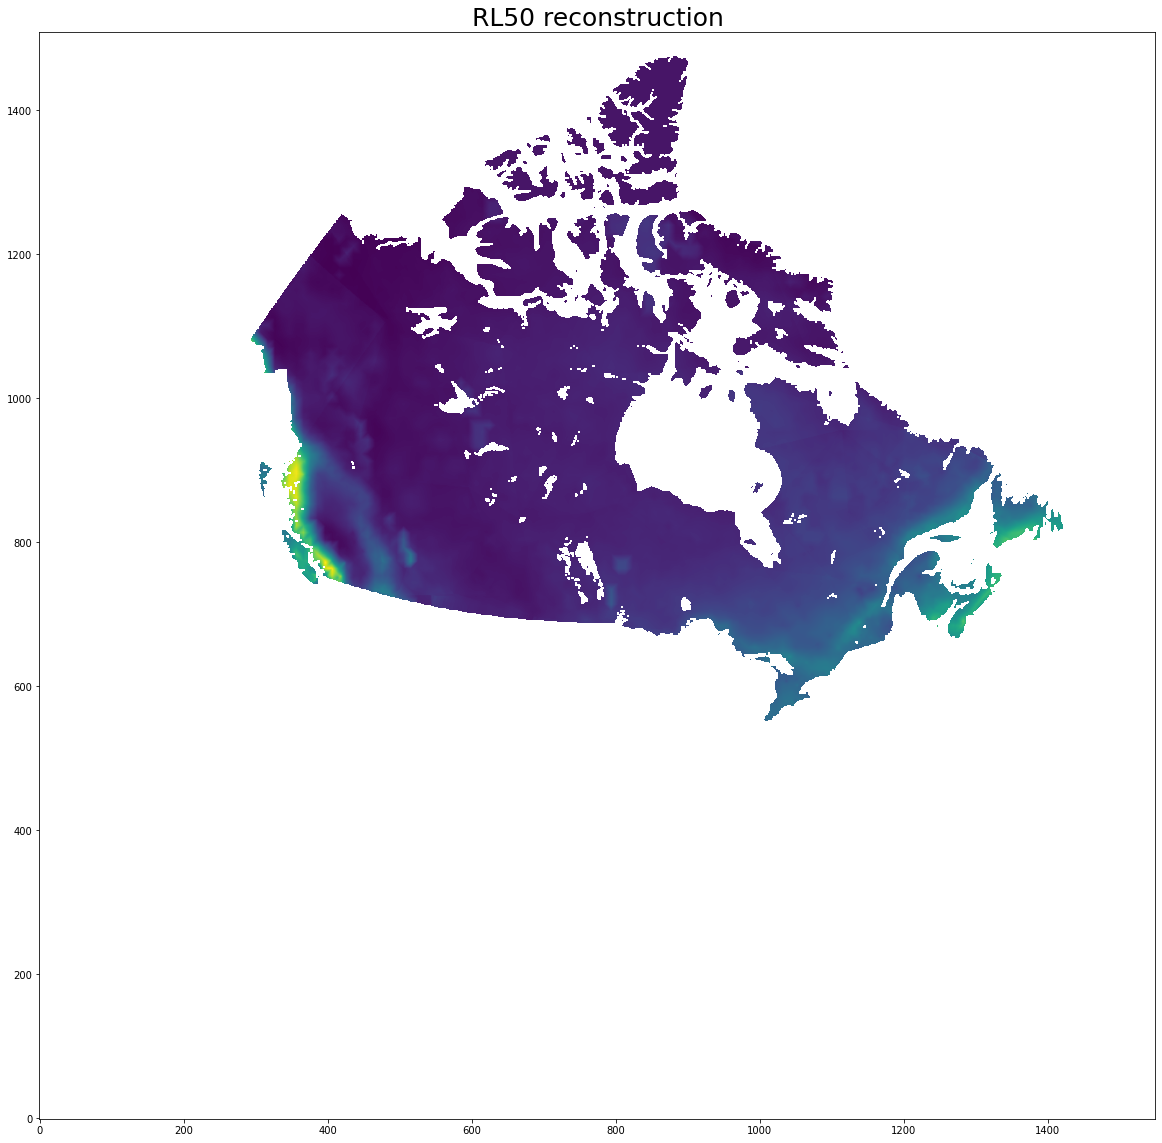

In [16]:
plt.figure(figsize=(20, 20))
plt.title(f"{name} reconstruction", fontsize=25)
plt.imshow(ds_recon[dv], origin='lower')